# Combine Binance and Twitter data

**Project Design Document:** https://docs.google.com/drawings/d/1JbpGdQX-BJsWonSfLEyi8_PxJepc_7Xjsn8U0kIOkLs/edit

## Setup

In [1]:
# Python 3.7.9

############### UNCOMMENT AND  RUN THIS TO INSTALL LIBRARIES

# ! pip install numpy==1.19.5
# ! pip install pandas==1.2.3
# ! pip install plotly==4.12.0

In [2]:
# Load libraries
import numpy as np
import pandas as pd
from pandas import json_normalize
from tqdm import tqdm
tqdm.pandas()

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})

import plotly
import plotly.express as px
import plotly.graph_objects as go

In [3]:
print("Python:", sys.version)
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Plotly:", plotly.__version__)

Python: 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
Numpy: 1.19.5
Pandas: 1.2.3
Plotly: 4.12.0


## Widgets

In [4]:
## Widgets
import ipywidgets as widgets

In [5]:
widgets.Text(value='Hello World!', disabled=True)

Text(value='Hello World!', disabled=True)

In [73]:
widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

## Load Binance dataset

In [6]:
# Binance
# binance_df = pd.read_csv("../data/ETHUSDT_1d_price_data.csv", index_col=0)
binance_df = pd.read_csv("../data/NMRUSDT_1d_price_data.csv", index_col=0)

In [7]:
binance_df.shape

(402, 18)

In [8]:
binance_df.head()

,open_time,close_time,open,high,low,close,volume,num_trades,MA_10,STD_10,Price_Change,Price_Change%,Change,upper_bound,lower_bound,above_bound,below_bound,cross_bounds
2020-08-20 02:59:59.999,2020-08-19 00:00:00.000,2020-08-19 23:59:59.999,50.42000,50.42000,37.77000,42.07900,11838.17200,4880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,neutral
2020-08-21 02:59:59.999,2020-08-20 00:00:00.000,2020-08-20 23:59:59.999,42.28100,53.88000,39.54200,46.93000,62972.51400,18560,NaN,NaN,4.85000,11.53000,Increase,NaN,NaN,False,False,neutral
2020-08-22 02:59:59.999,2020-08-21 00:00:00.000,2020-08-21 23:59:59.999,46.95200,52.10000,41.35200,41.89600,47528.20400,19241,NaN,NaN,-5.03000,-10.73000,Decrease,NaN,NaN,False,False,neutral
2020-08-23 02:59:59.999,2020-08-22 00:00:00.000,2020-08-22 23:59:59.999,42.18100,51.00000,41.07200,47.97800,19932.14700,8238,NaN,NaN,6.08000,14.52000,Increase,NaN,NaN,False,False,neutral
2020-08-24 02:59:59.999,2020-08-23 00:00:00.000,2020-08-23 23:59:59.999,48.04800,48.05700,42.82800,43.59100,17284.85500,6039,NaN,NaN,-4.39000,-9.14000,Decrease,NaN,NaN,False,False,neutral


In [9]:
# Create open_time_date column
binance_df["open_time_date"] = pd.to_datetime(binance_df["open_time"])

In [10]:
binance_df.dtypes

open_time                 object
close_time                object
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
num_trades                 int64
MA_10                    float64
STD_10                   float64
Price_Change             float64
Price_Change%            float64
Change                    object
upper_bound              float64
lower_bound              float64
above_bound                 bool
below_bound                 bool
cross_bounds              object
open_time_date    datetime64[ns]
dtype: object

In [11]:
## Conclusions

# - There aren't any day crossing both upper and low bound!
# - There are 38 days crossing above bound
# - There are 31 days crossing below bound

binance_df[["above_bound", "below_bound"]].value_counts()

above_bound  below_bound
False        False          349
True         False           43
False        True             9
True         True             1
dtype: int64

In [12]:
# Create cross_bounds columns [above, below, neutral]

def create_cross_bounds(row):
    if row['above_bound'] :
        return 'above'
    elif row['below_bound'] :
        return 'below'
    else:
        return "neutral"
    
binance_df["cross_bounds"] = binance_df.apply(lambda row: create_cross_bounds(row), axis=1)

## Load twitter dataset

In [13]:
## Load tweets

# tweets_df = pd.read_csv("../data/ETH_twitter_api_sentiment.csv", index_col=0)
tweets_df = pd.read_csv("../data/NMR_twitter_api_sentiment.csv")

In [14]:
tweets_df.shape

(24808, 11)

In [15]:
tweets_df.head()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count,created_at_date,created_at_date_hour,sentiment
0,1141208687001780225,2021-08-30 23:46:47+00:00,1432490010046078977,$nmr\n🔻 decreased 4.34% in 9.8 hour(s)\n💵 pric...,0,0,0,0,2021-08-30,2021-08-30 23,0.00000
1,1150271775273619456,2021-08-30 23:41:40+00:00,1432488721979527169,$bnt $crv $nmr $ogn $rep $req $cvc $mln keep a...,3,0,1,0,2021-08-30,2021-08-30 23,0.12800
2,23025079,2021-08-30 23:21:26+00:00,1432483630341820421,$coti added some 33s 💁‍♂️🙈\n$btc $eth $mkr $aa...,4,1,14,1,2021-08-30,2021-08-30 23,0.00000
3,1329640297760911361,2021-08-30 23:09:30+00:00,1432480627274629130,no monster no gain!\n\nmarket analysis &amp; r...,0,0,0,0,2021-08-30,2021-08-30 23,0.40270
4,2896209087,2021-08-30 22:52:57+00:00,1432476464742608906,$nmr decision time is coming soon. i see two p...,3,0,1,0,2021-08-30,2021-08-30 22,0.00000


In [16]:
# Fix date column
tweets_df["created_at_date"] = pd.to_datetime(tweets_df["created_at_date"])

In [17]:
tweets_df.dtypes

author_id                        int64
created_at                      object
tweet_id                         int64
text                            object
like_count                       int64
quote_count                      int64
reply_count                      int64
retweet_count                    int64
created_at_date         datetime64[ns]
created_at_date_hour            object
sentiment                      float64
dtype: object

In [18]:
## Fix columns
tweets_df["like_count"] = pd.to_numeric(tweets_df["like_count"],  errors='coerce')
tweets_df["quote_count"] = pd.to_numeric(tweets_df["quote_count"],  errors='coerce')
tweets_df["reply_count"] = pd.to_numeric(tweets_df["reply_count"],  errors='coerce')
tweets_df["retweet_count"] = pd.to_numeric(tweets_df["retweet_count"],  errors='coerce')

In [19]:
# Create weighted_sentiment_v1

# ['like_count', 'quote_count', 'reply_count', 'retweet_count']

tweets_df["weighted_sentiment_v1"] = tweets_df["sentiment"] * tweets_df["like_count"]
tweets_df["weighted_sentiment_v2"] = tweets_df["sentiment"] * tweets_df["quote_count"]
tweets_df["weighted_sentiment_v3"] = tweets_df["sentiment"] * tweets_df["reply_count"]
tweets_df["weighted_sentiment_v4"] = tweets_df["sentiment"] * tweets_df["retweet_count"]

tweets_df["weighted_sentiment_v5"] = tweets_df["sentiment"] * (tweets_df["like_count"]+tweets_df["retweet_count"])
tweets_df["weighted_sentiment_v6"] = tweets_df["sentiment"] * (tweets_df["like_count"]+tweets_df["quote_count"]+tweets_df["reply_count"]+tweets_df["retweet_count"])

In [20]:
tweets_df[["sentiment",
           "weighted_sentiment_v1","weighted_sentiment_v2","weighted_sentiment_v3",
           "weighted_sentiment_v4","weighted_sentiment_v5","weighted_sentiment_v6"]].describe()

,sentiment,weighted_sentiment_v1,weighted_sentiment_v2,weighted_sentiment_v3,weighted_sentiment_v4,weighted_sentiment_v5,weighted_sentiment_v6
count,24808.00000,24808.00000,24808.00000,24808.00000,24808.00000,24808.00000,24808.00000
mean,0.28982,0.82310,0.02286,0.09544,0.17207,0.99518,1.11348
std,0.43684,7.43767,0.24868,1.42404,1.81234,9.04719,10.05378
min,-0.99060,-74.03700,-2.39760,-39.31620,-35.67240,-79.14300,-119.48040
25%,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000
50%,0.31820,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.70030,0.12800,0.00000,0.00000,0.00000,0.29600,0.40710
max,0.98840,799.08120,13.78620,121.57840,143.04540,942.12660,965.96750


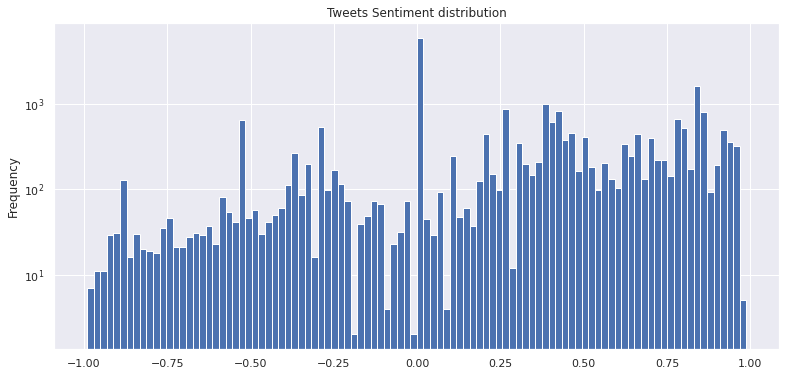

In [21]:
tweets_df["sentiment"].plot.hist(bins=100, title="Tweets Sentiment distribution",logy=True);

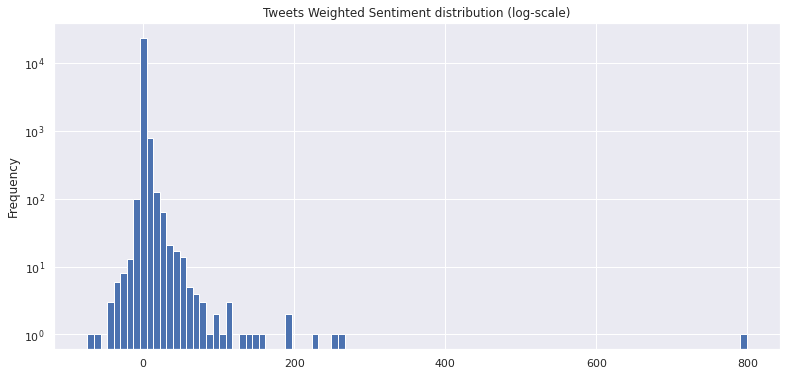

In [22]:
tweets_df["weighted_sentiment_v1"].plot.hist(bins=100,
                                            logy=True,
                                            title="Tweets Weighted Sentiment distribution (log-scale)");

In [23]:
## Aggregate per Day

tweets_sentiment_per_day_df = (tweets_df
                              .groupby('created_at_date')
                              .agg({'sentiment':["mean","median"],
                                    'weighted_sentiment_v1':["mean","median"],
                                    'weighted_sentiment_v2':["mean","median"],
                                    'weighted_sentiment_v3':["mean","median"],
                                    'weighted_sentiment_v4':["mean","median"],
                                    'weighted_sentiment_v5':["mean","median"],
                                    'weighted_sentiment_v6':["mean","median"]}))

tweets_sentiment_per_day_df = tweets_sentiment_per_day_df.reset_index()

tweets_sentiment_per_day_df.columns = ["_".join(x) for x in tweets_sentiment_per_day_df.columns]
tweets_sentiment_per_day_df = tweets_sentiment_per_day_df.rename(columns={"created_at_date_":"created_at_date"})

In [24]:
tweets_sentiment_per_day_df.head()

,created_at_date,sentiment_mean,sentiment_median,weighted_sentiment_v1_mean,weighted_sentiment_v1_median,weighted_sentiment_v2_mean,weighted_sentiment_v2_median,weighted_sentiment_v3_mean,weighted_sentiment_v3_median,weighted_sentiment_v4_mean,weighted_sentiment_v4_median,weighted_sentiment_v5_mean,weighted_sentiment_v5_median,weighted_sentiment_v6_mean,weighted_sentiment_v6_median
0,2020-01-01,0.37254,0.40190,0.35519,0.00000,0.09926,0.00000,0.19851,0.00000,0.00000,0.00000,0.35519,0.00000,0.65296,0.00000
1,2020-01-02,0.35778,0.42030,-0.52253,0.00000,0.00000,0.00000,-0.06532,0.00000,-0.06532,0.00000,-0.58785,0.00000,-0.65317,0.00000
2,2020-01-03,0.29875,0.37455,-0.29402,0.00000,0.00000,0.00000,0.00000,0.00000,-0.23884,0.00000,-0.53286,0.00000,-0.53286,0.00000
3,2020-01-04,0.58883,0.56465,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,2020-01-05,0.65783,0.67050,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


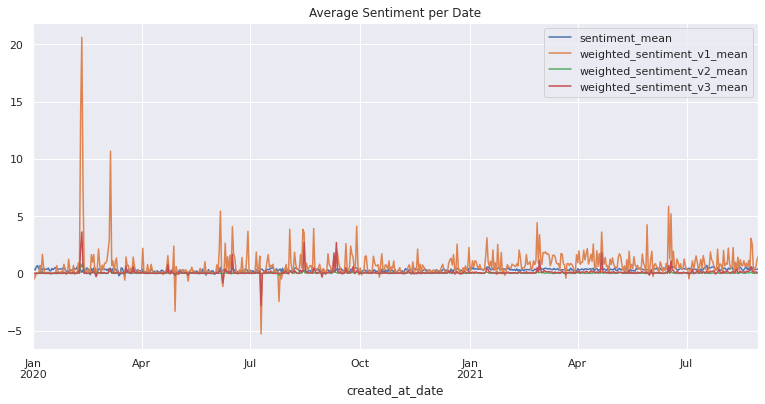

In [25]:
## Plot Average sentiment

# ylim=[-1,1]

ax1 = tweets_sentiment_per_day_df.plot.line(x="created_at_date",
                                            y="sentiment_mean");

ax2 = tweets_sentiment_per_day_df.plot.line(ax=ax1,
                                            x="created_at_date",
                                            y="weighted_sentiment_v1_mean",
                                            title="Average Sentiment per Date");

ax3 = tweets_sentiment_per_day_df.plot.line(ax=ax2,
                                            x="created_at_date",
                                            y="weighted_sentiment_v2_mean",
                                            title="Average Sentiment per Date");


ax4 = tweets_sentiment_per_day_df.plot.line(ax=ax3,
                                            x="created_at_date",
                                            y="weighted_sentiment_v3_mean",
                                            title="Average Sentiment per Date");

## Combine datasets [binance_df, tweets_sentiment_per_day_df]

In [26]:
binance_df.head()

,open_time,close_time,open,high,low,close,volume,num_trades,MA_10,STD_10,Price_Change,Price_Change%,Change,upper_bound,lower_bound,above_bound,below_bound,cross_bounds,open_time_date
2020-08-20 02:59:59.999,2020-08-19 00:00:00.000,2020-08-19 23:59:59.999,50.42000,50.42000,37.77000,42.07900,11838.17200,4880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,neutral,2020-08-19
2020-08-21 02:59:59.999,2020-08-20 00:00:00.000,2020-08-20 23:59:59.999,42.28100,53.88000,39.54200,46.93000,62972.51400,18560,NaN,NaN,4.85000,11.53000,Increase,NaN,NaN,False,False,neutral,2020-08-20
2020-08-22 02:59:59.999,2020-08-21 00:00:00.000,2020-08-21 23:59:59.999,46.95200,52.10000,41.35200,41.89600,47528.20400,19241,NaN,NaN,-5.03000,-10.73000,Decrease,NaN,NaN,False,False,neutral,2020-08-21
2020-08-23 02:59:59.999,2020-08-22 00:00:00.000,2020-08-22 23:59:59.999,42.18100,51.00000,41.07200,47.97800,19932.14700,8238,NaN,NaN,6.08000,14.52000,Increase,NaN,NaN,False,False,neutral,2020-08-22
2020-08-24 02:59:59.999,2020-08-23 00:00:00.000,2020-08-23 23:59:59.999,48.04800,48.05700,42.82800,43.59100,17284.85500,6039,NaN,NaN,-4.39000,-9.14000,Decrease,NaN,NaN,False,False,neutral,2020-08-23


In [27]:
tweets_sentiment_per_day_df.head()

,created_at_date,sentiment_mean,sentiment_median,weighted_sentiment_v1_mean,weighted_sentiment_v1_median,weighted_sentiment_v2_mean,weighted_sentiment_v2_median,weighted_sentiment_v3_mean,weighted_sentiment_v3_median,weighted_sentiment_v4_mean,weighted_sentiment_v4_median,weighted_sentiment_v5_mean,weighted_sentiment_v5_median,weighted_sentiment_v6_mean,weighted_sentiment_v6_median
0,2020-01-01,0.37254,0.40190,0.35519,0.00000,0.09926,0.00000,0.19851,0.00000,0.00000,0.00000,0.35519,0.00000,0.65296,0.00000
1,2020-01-02,0.35778,0.42030,-0.52253,0.00000,0.00000,0.00000,-0.06532,0.00000,-0.06532,0.00000,-0.58785,0.00000,-0.65317,0.00000
2,2020-01-03,0.29875,0.37455,-0.29402,0.00000,0.00000,0.00000,0.00000,0.00000,-0.23884,0.00000,-0.53286,0.00000,-0.53286,0.00000
3,2020-01-04,0.58883,0.56465,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,2020-01-05,0.65783,0.67050,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [28]:
# Merge dataset
df = binance_df.merge(tweets_sentiment_per_day_df,
                      left_on = "open_time_date",
                      right_on = "created_at_date",
                      how="inner")

In [29]:
# Check shape (8 months x ~30 days)
df.shape

(377, 34)

# Analysis

**Final Outputs**


**General**

1. Candlestick plot (prices and boudaries) [Binance data]
2. Table for all tweets (raw) [Twitter data]


**For all days**

3. Combined Table per date (Prices, Price change, Aggregated Sentiment, Weighted Aggregated sentiment)
4. Correlation plot 
5. Correlation table

**Intra day**

6. Table with day's tweets
7. Plot with most liked tweets for this day

## General

In [51]:
symbol="ETHUSDT"
window=10
std_times=2

In [52]:
## Plotly 

# candlestick plot
fig = go.Figure(data=[go.Candlestick(x=df["open_time"],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.update_layout(
    yaxis_title="USDT",
    title={
        'text': symbol + " Price and cross-points",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# MA plot
fig.add_trace(
    go.Scatter(
        x = df["open_time"],
        y = df[f"MA_{window}"],
        name = "Moving average",
        mode="lines",
        line=go.scatter.Line(color="black", dash="dash"),
        showlegend=True)
)


# Upper bound
fig.add_trace(
    go.Scatter(
        x= df["open_time"],
        y= df[f"MA_{window}"] + std_times * df[f"STD_{window}"],
        name = "Upper bound",
        mode="lines",
        line=go.scatter.Line(color="lightgreen"),
        showlegend=True)
)

# Lower bound
fig.add_trace(
    go.Scatter(
        x = df["open_time"],
        y = df[f"MA_{window}"] - std_times * df[f"STD_{window}"],
        name = "Lower bound",
        mode="lines",
        line=go.scatter.Line(color="firebrick"),
        showlegend=True)
)


## Plot crossing points

low_value = int(df[['open','high','low','close']].min().min() - 10)

fig.add_trace(go.Scatter(
    x = df.loc[df['above_bound'], "open_time"],
    y = np.repeat(low_value, len(df.loc[df['above_bound'], "open_time"])),
    marker=dict(color="green", size=4),
    mode="markers",
    name = 'above_boundary'
))


fig.add_trace(go.Scatter(
    x = df.loc[df['below_bound'], "open_time"],
    y = np.repeat(low_value, len(df.loc[df['below_bound'], "open_time"])),
    marker=dict(color="crimson", size=4),
    mode="markers",
    name = 'below_boundary'
))


fig.show()

In [54]:
# Check raw tweets dataset
tweets_df.head(2)

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count,created_at_date,created_at_date_hour,sentiment,weighted_sentiment_v1,weighted_sentiment_v2,weighted_sentiment_v3,weighted_sentiment_v4,weighted_sentiment_v5,weighted_sentiment_v6
0,1141208687001780225,2021-08-30 23:46:47+00:00,1432490010046078977,$nmr\n🔻 decreased 4.34% in 9.8 hour(s)\n💵 price - 42.81000000 usdt\n⏱️ [30 aug] - 23:46:47 utc\n#nmr #nmrusdt #cryptobot,0,0,0,0,2021-08-30,2021-08-30 23,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,1150271775273619456,2021-08-30 23:41:40+00:00,1432488721979527169,$bnt $crv $nmr $ogn $rep $req $cvc $mln keep an eye out for these coins exploding soon as i have a feeling 🙏🏽,3,0,1,0,2021-08-30,2021-08-30 23,0.12800,0.38400,0.00000,0.12800,0.00000,0.38400,0.51200


## Correlation for all days

In [55]:
# Check final dataset (price and aggregated sentiment, per day)
df.head()

,open_time,close_time,open,high,low,close,volume,num_trades,MA_10,STD_10,Price_Change,Price_Change%,Change,upper_bound,lower_bound,above_bound,below_bound,cross_bounds,open_time_date,created_at_date,sentiment_mean,sentiment_median,weighted_sentiment_v1_mean,weighted_sentiment_v1_median,weighted_sentiment_v2_mean,weighted_sentiment_v2_median,weighted_sentiment_v3_mean,weighted_sentiment_v3_median,weighted_sentiment_v4_mean,weighted_sentiment_v4_median,weighted_sentiment_v5_mean,weighted_sentiment_v5_median,weighted_sentiment_v6_mean,weighted_sentiment_v6_median
0,2020-08-19 00:00:00.000,2020-08-19 23:59:59.999,50.42000,50.42000,37.77000,42.07900,11838.17200,4880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,neutral,2020-08-19,2020-08-19,0.24123,0.22630,0.47087,-0.00000,0.01095,0.00000,0.04135,-0.00000,0.18550,-0.00000,0.65636,-0.00000,0.70867,-0.00000
1,2020-08-20 00:00:00.000,2020-08-20 23:59:59.999,42.28100,53.88000,39.54200,46.93000,62972.51400,18560,NaN,NaN,4.85000,11.53000,Increase,NaN,NaN,False,False,neutral,2020-08-20,2020-08-20,0.23878,0.38180,0.68132,0.00000,0.05805,0.00000,0.08243,0.00000,0.14152,0.00000,0.82284,0.00000,0.96332,0.00000
2,2020-08-21 00:00:00.000,2020-08-21 23:59:59.999,46.95200,52.10000,41.35200,41.89600,47528.20400,19241,NaN,NaN,-5.03000,-10.73000,Decrease,NaN,NaN,False,False,neutral,2020-08-21,2020-08-21,0.12301,0.00000,0.65916,0.00000,0.01934,0.00000,0.02691,0.00000,0.21391,0.00000,0.87307,0.00000,0.91932,0.00000
3,2020-08-22 00:00:00.000,2020-08-22 23:59:59.999,42.18100,51.00000,41.07200,47.97800,19932.14700,8238,NaN,NaN,6.08000,14.52000,Increase,NaN,NaN,False,False,neutral,2020-08-22,2020-08-22,0.18288,0.27320,0.05590,0.00000,0.00000,0.00000,0.00907,0.00000,-0.00022,0.00000,0.05569,0.00000,0.06475,0.00000
4,2020-08-23 00:00:00.000,2020-08-23 23:59:59.999,48.04800,48.05700,42.82800,43.59100,17284.85500,6039,NaN,NaN,-4.39000,-9.14000,Decrease,NaN,NaN,False,False,neutral,2020-08-23,2020-08-23,0.22002,0.38180,3.90999,0.00000,0.06666,0.00000,0.46834,0.00000,0.86987,0.00000,4.77986,0.00000,5.31485,0.00000


In [72]:
## Scatter Plot 

x_axis = "Price_Change" # "Price_Change%"
y_axis = "weighted_sentiment_v5_mean" # "weighted_sentiment_v2_mean"


fig = px.scatter(df,
                 x=x_axis, # Price_Change%
                 y=y_axis, # weighted_sentiment_v1_mean
                 color="cross_bounds",
                 color_discrete_sequence=["grey", "green", "red"],
                 hover_name="open_time_date",
                 title="Price Change vs Average Sentiment")

fig.show()

In [57]:
print("Correlation between Price Change and Average Sentiment")

# df[["Price_Change","sentiment_mean"]].corr()
df[["Price_Change","Price_Change%",
    "sentiment_mean",
    "weighted_sentiment_v1_mean","weighted_sentiment_v2_mean","weighted_sentiment_v3_mean",
    "weighted_sentiment_v4_mean","weighted_sentiment_v5_mean","weighted_sentiment_v6_mean"]].corr()

Correlation between Price Change and Average Sentiment


,Price_Change,Price_Change%,sentiment_mean,weighted_sentiment_v1_mean,weighted_sentiment_v2_mean,weighted_sentiment_v3_mean,weighted_sentiment_v4_mean,weighted_sentiment_v5_mean,weighted_sentiment_v6_mean
Price_Change,1.00000,0.95051,0.05861,0.08342,0.04313,-0.03010,0.01625,0.07050,0.05656
Price_Change%,0.95051,1.00000,0.05912,0.08009,0.03351,-0.02314,0.02624,0.07016,0.05730
sentiment_mean,0.05861,0.05912,1.00000,0.26233,0.13085,0.13192,0.18153,0.25194,0.24662
weighted_sentiment_v1_mean,0.08342,0.08009,0.26233,1.00000,0.60838,0.52412,0.82608,0.99145,0.97408
weighted_sentiment_v2_mean,0.04313,0.03351,0.13085,0.60838,1.00000,0.48766,0.52674,0.60877,0.64695
weighted_sentiment_v3_mean,-0.03010,-0.02314,0.13192,0.52412,0.48766,1.00000,0.56576,0.55039,0.67871
weighted_sentiment_v4_mean,0.01625,0.02624,0.18153,0.82608,0.52674,0.56576,1.00000,0.89256,0.89406
weighted_sentiment_v5_mean,0.07050,0.07016,0.25194,0.99145,0.60877,0.55039,0.89256,1.00000,0.98645
weighted_sentiment_v6_mean,0.05656,0.05730,0.24662,0.97408,0.64695,0.67871,0.89406,0.98645,1.00000


In [58]:
## Price Change and Average sentiment per Day

df2 = df[["open_time_date",
          "close", "Price_Change", "Price_Change%", "cross_bounds",
          "sentiment_mean","weighted_sentiment_v1_mean"]]

## Sort days based on sentiment

# "sentiment_mean", "weighted_sentiment_v1_mean"
df2.sort_values("sentiment_mean",ascending=False)

,open_time_date,close,Price_Change,Price_Change%,cross_bounds,sentiment_mean,weighted_sentiment_v1_mean
333,2021-07-18,30.56000,-0.05000,-0.17000,neutral,0.69409,0.27542
339,2021-07-24,32.82500,0.47000,1.44000,neutral,0.60896,0.46971
305,2021-06-20,36.70300,0.16000,0.43000,neutral,0.59028,1.93422
306,2021-06-21,30.39300,-6.31000,-17.19000,neutral,0.56299,0.41865
303,2021-06-18,38.64400,-0.01000,-0.03000,neutral,0.55674,5.19574
...,...,...,...,...,...,...,...
14,2020-09-02,48.99800,-1.89000,-3.72000,neutral,0.05612,-0.03948
222,2021-03-29,48.31800,2.51000,5.47000,neutral,0.04498,0.19985
73,2020-10-31,23.23300,-1.00000,-4.11000,neutral,0.03429,0.05591
59,2020-10-17,28.63600,0.32000,1.15000,neutral,0.02815,-0.33480


In [59]:
# Table per day

# - Days with Negative Price action
# df2.query("cross_bounds=='below'")

# - Days with Positive Price action
# df2.query("cross_bounds=='above'").sort_values("sentiment_mean")

## Intra day

In [63]:
select_date = "2021-08-07"

In [64]:
# Extract tweets for specifc date
intra_day_tweets = tweets_df.query("created_at_date == @select_date")
print(f"There are {len(intra_day_tweets)} tweets for this date")

There are 55 tweets for this date


In [65]:
## Check day's tweets
intra_day_tweets.sort_values("like_count", ascending=False).head(5)

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count,created_at_date,created_at_date_hour,sentiment,weighted_sentiment_v1,weighted_sentiment_v2,weighted_sentiment_v3,weighted_sentiment_v4,weighted_sentiment_v5,weighted_sentiment_v6
1021,948551073387642880,2021-08-07 12:32:09+00:00,1423985311504293894,[scan results - 15m - #usdt pair]\n\nbinance top 5 bullish strength\n1: $nmr\n2: $uni\n3: $ltc\n4: $ksm\n5: $wnxm\n\nbinance top 5 bullish reversal strength\n1: $unfi\n2: $super\n3: $fio\n4: $gtc\n5: $rlc,5,0,0,1,2021-08-07,2021-08-07 12,0.91690,4.58450,0.00000,0.00000,0.91690,5.50140,5.50140
1004,948551073387642880,2021-08-07 16:47:01+00:00,1424049452369731586,[scan results - 15m - #usdt pair]\n\nbinance top 5 bullish strength\n1: $mask\n2: $doge\n3: $ckb\n4: $xvs\n5: $nmr\n\nbinance top 5 bullish reversal strength\n1: $nano\n2: $mdx\n3: $wnxm\n4: $paxg\n5: $bake,5,0,1,0,2021-08-07,2021-08-07 16,0.84020,4.20100,0.00000,0.84020,0.00000,4.20100,5.04120
1041,948551073387642880,2021-08-07 02:31:44+00:00,1423834213669867522,[scan results - 15m - #usdt pair]\n\nbinance top 5 bullish strength\n1: $eth\n2: $doge\n3: $nmr\n4: $sushi\n5: $cvc\n\nbinance top 5 bullish reversal strength\n1: $clv\n2: $ocean\n3: $qnt\n4: $tomo\n5: $tlm,4,0,1,0,2021-08-07,2021-08-07 2,0.84020,3.36080,0.00000,0.84020,0.00000,3.36080,4.20100
1031,948551073387642880,2021-08-07 06:46:53+00:00,1423898421719666690,[scan results - 15m - #usdt pair]\n\nbinance top 5 bullish strength\n1: $ern\n2: $chr\n3: $nmr\n4: $vet\n5: $xvg\n\nbinance top 5 bullish reversal strength\n1: $sun\n2: $iotx\n3: $nu\n4: $knc\n5: $rep,4,0,0,2,2021-08-07,2021-08-07 6,0.84020,3.36080,0.00000,0.00000,1.68040,5.04120,5.04120
996,948551073387642880,2021-08-07 19:17:04+00:00,1424087213164404745,[scan results - 15m - #usdt pair]\n\nbinance top 5 bullish strength\n1: $torn\n2: $nmr\n3: $ctxc\n4: $dodo\n5: $xem\n\nbinance top 5 bullish reversal strength\n1: $chr\n2: $uni\n3: $dego\n4: $hbar\n5: $kmd,3,0,0,0,2021-08-07,2021-08-07 19,0.79060,2.37180,0.00000,0.00000,0.00000,2.37180,2.37180


In [66]:
# Plot: Check most liked tweets

y_axis = "like_count" # 'quote_count', ''

fig = px.line(intra_day_tweets,
              x="created_at", y=,
              title=f'{select_date} | Intra-day Likes on tweets',
              hover_name="author_id", # username
              hover_data=["created_at", "like_count","tweet_id","text"])
fig.show()

In [41]:
### Save the plot in the path you want! 
# fig.write_html("../outcome/Intra-day Likes on tweets.html")

In [67]:
## Plot: Sentiment vs Likes

fig = px.scatter(intra_day_tweets,
                 x="sentiment", y="like_count",
                 title=f'{select_date} | Sentiment vs Likes',
                 hover_name="author_id", # username
                 hover_data=["created_at", "like_count","tweet_id","text"])
fig.show()

In [43]:
### Save the plot in the path you want! 
# fig.write_html("../outcome/sentiment_vs_likes.html")

In [68]:
## Intra-day likes vs sentiment correlation
intra_day_tweets[["like_count","sentiment"]].corr()

,like_count,sentiment
like_count,1.00000,0.05450
sentiment,0.05450,1.00000


## App

**TODO**

1. About, Introduction, Description (formulas, design document, etc)
2. Filter, Sort, Select in pd DataFrame in Stremlit app
3. Connect Plotly graph with tweets table (click plotly app and update tweets table)